In [1]:
## Import Packages
import numpy as np
import _pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import os 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [2]:
Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/Data/'
mods = ['CanESM2','CanESM5_p2']

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

landmask_source = '/Volumes/eSSD0/Papers/GMD_CanESM_p2/Analysis/Control/'
CanESM5 = pk.load(open(landmask_source+'results/CanESM5_CCF_picon.pi','rb'))
landmask = np.isnan(CanESM5['TADV'][0,:,:])
landvalid = np.isfinite(CanESM5['TADV'][0,:,:])
landmask_ext = np.tile(landmask[None,:,:],(150,1,1))

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,:,None],(lon.size,1,150)).T
coslat_subtrop = coslat[:,10:54,:]
coslat_trop = coslat[:,21:43,:]

SST_time = {}
SST_picon = {}
SST_picon_gam = {}
for m in range(2):
    SST_time[mods[m]] = pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_x4_TmSrs.pi','rb'))
    SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)

SST_time['piForcing'] = pk.load(open(Source+mods[m]+'/CFMIP/Tier_2/CanESM5_p2_SST_Tmsrs.pi','rb'))

<ipython-input-2-619b1e7402ff>:24: RuntimeWarning: Mean of empty slice
  SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)


In [3]:
SST_trop = {}
for models in SST_time.keys():

    if models == 'piForcing':
        SST_time[models][landmask_ext[:145,:,:]] = np.nan
    else:
        SST_time[models][landmask_ext] = np.nan
        
    SST_trop[models] = np.ma.masked_invalid(SST_time[models][:,21:43,:])

In [4]:
#get the 70th percentile
SST_filled = {}
SST_thresh = {}
SST_top30 = {}
for models in SST_time.keys():
    SST_filled[models] = np.ma.filled(SST_trop[models], np.nan)
    SST_thresh[models] = np.nanpercentile(SST_filled[models],70,axis=(1,2))

    if models == 'piForcing':
        nyrs = 145
    else:
        nyrs = 150

    SST_top30[models] = np.zeros([nyrs,22,128])

    for i in range(nyrs):
        SST_top30[models][i] = np.where(SST_filled[models][i,:,:]>SST_thresh[models][i],SST_filled[models][i,:,:],np.nan)


    SST_top30[models] = np.ma.masked_invalid(SST_top30[models])

In [5]:
SST_mn = {}
SST_T30_mn = {}
SST_sharp = {}
for models in SST_time.keys():

    if models == 'piForcing':
        coslat_trop = coslat[:145,21:43,:]
    else:
        coslat_trop = coslat[:,21:43,:]
        
    SST_mn[models] = np.ma.average(SST_trop[models],weights=coslat_trop,axis=(1,2))
    SST_T30_mn[models] = np.ma.average(SST_top30[models],weights=coslat_trop,axis=(1,2))
    SST_sharp[models] = SST_T30_mn[models]-SST_mn[models]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
years = np.arange(150).reshape(-1,1)
ESM2_fit = LinearRegression().fit(years,SST_sharp['CanESM2'])
ESM2_pred = ESM2_fit.predict(years)
ESM2_alpha = ESM2_fit.coef_
ESM5_fit = LinearRegression().fit(years,SST_sharp['CanESM5_p2'])
ESM5_pred = ESM5_fit.predict(years)
ESM5_alpha = ESM5_fit.coef_

piForc_fit = LinearRegression().fit(years[:145],SST_sharp['piForcing'])
piForc_pred = piForc_fit.predict(years[:145])
piForc_alpha = piForc_fit.coef_

In [7]:
SST_picon_plot = {}
for mods in SST_picon.keys():

    SST_picon_plot[mods] = np.concatenate((SST_picon[mods][:,64:],SST_picon[mods][:,0:64]),axis=1)
    SST_picon_plot[mods],lon_cyc = add_cyclic_point(SST_picon_plot[mods],lon)

delta = SST_picon_plot['CanESM5_p2']-SST_picon_plot['CanESM2']

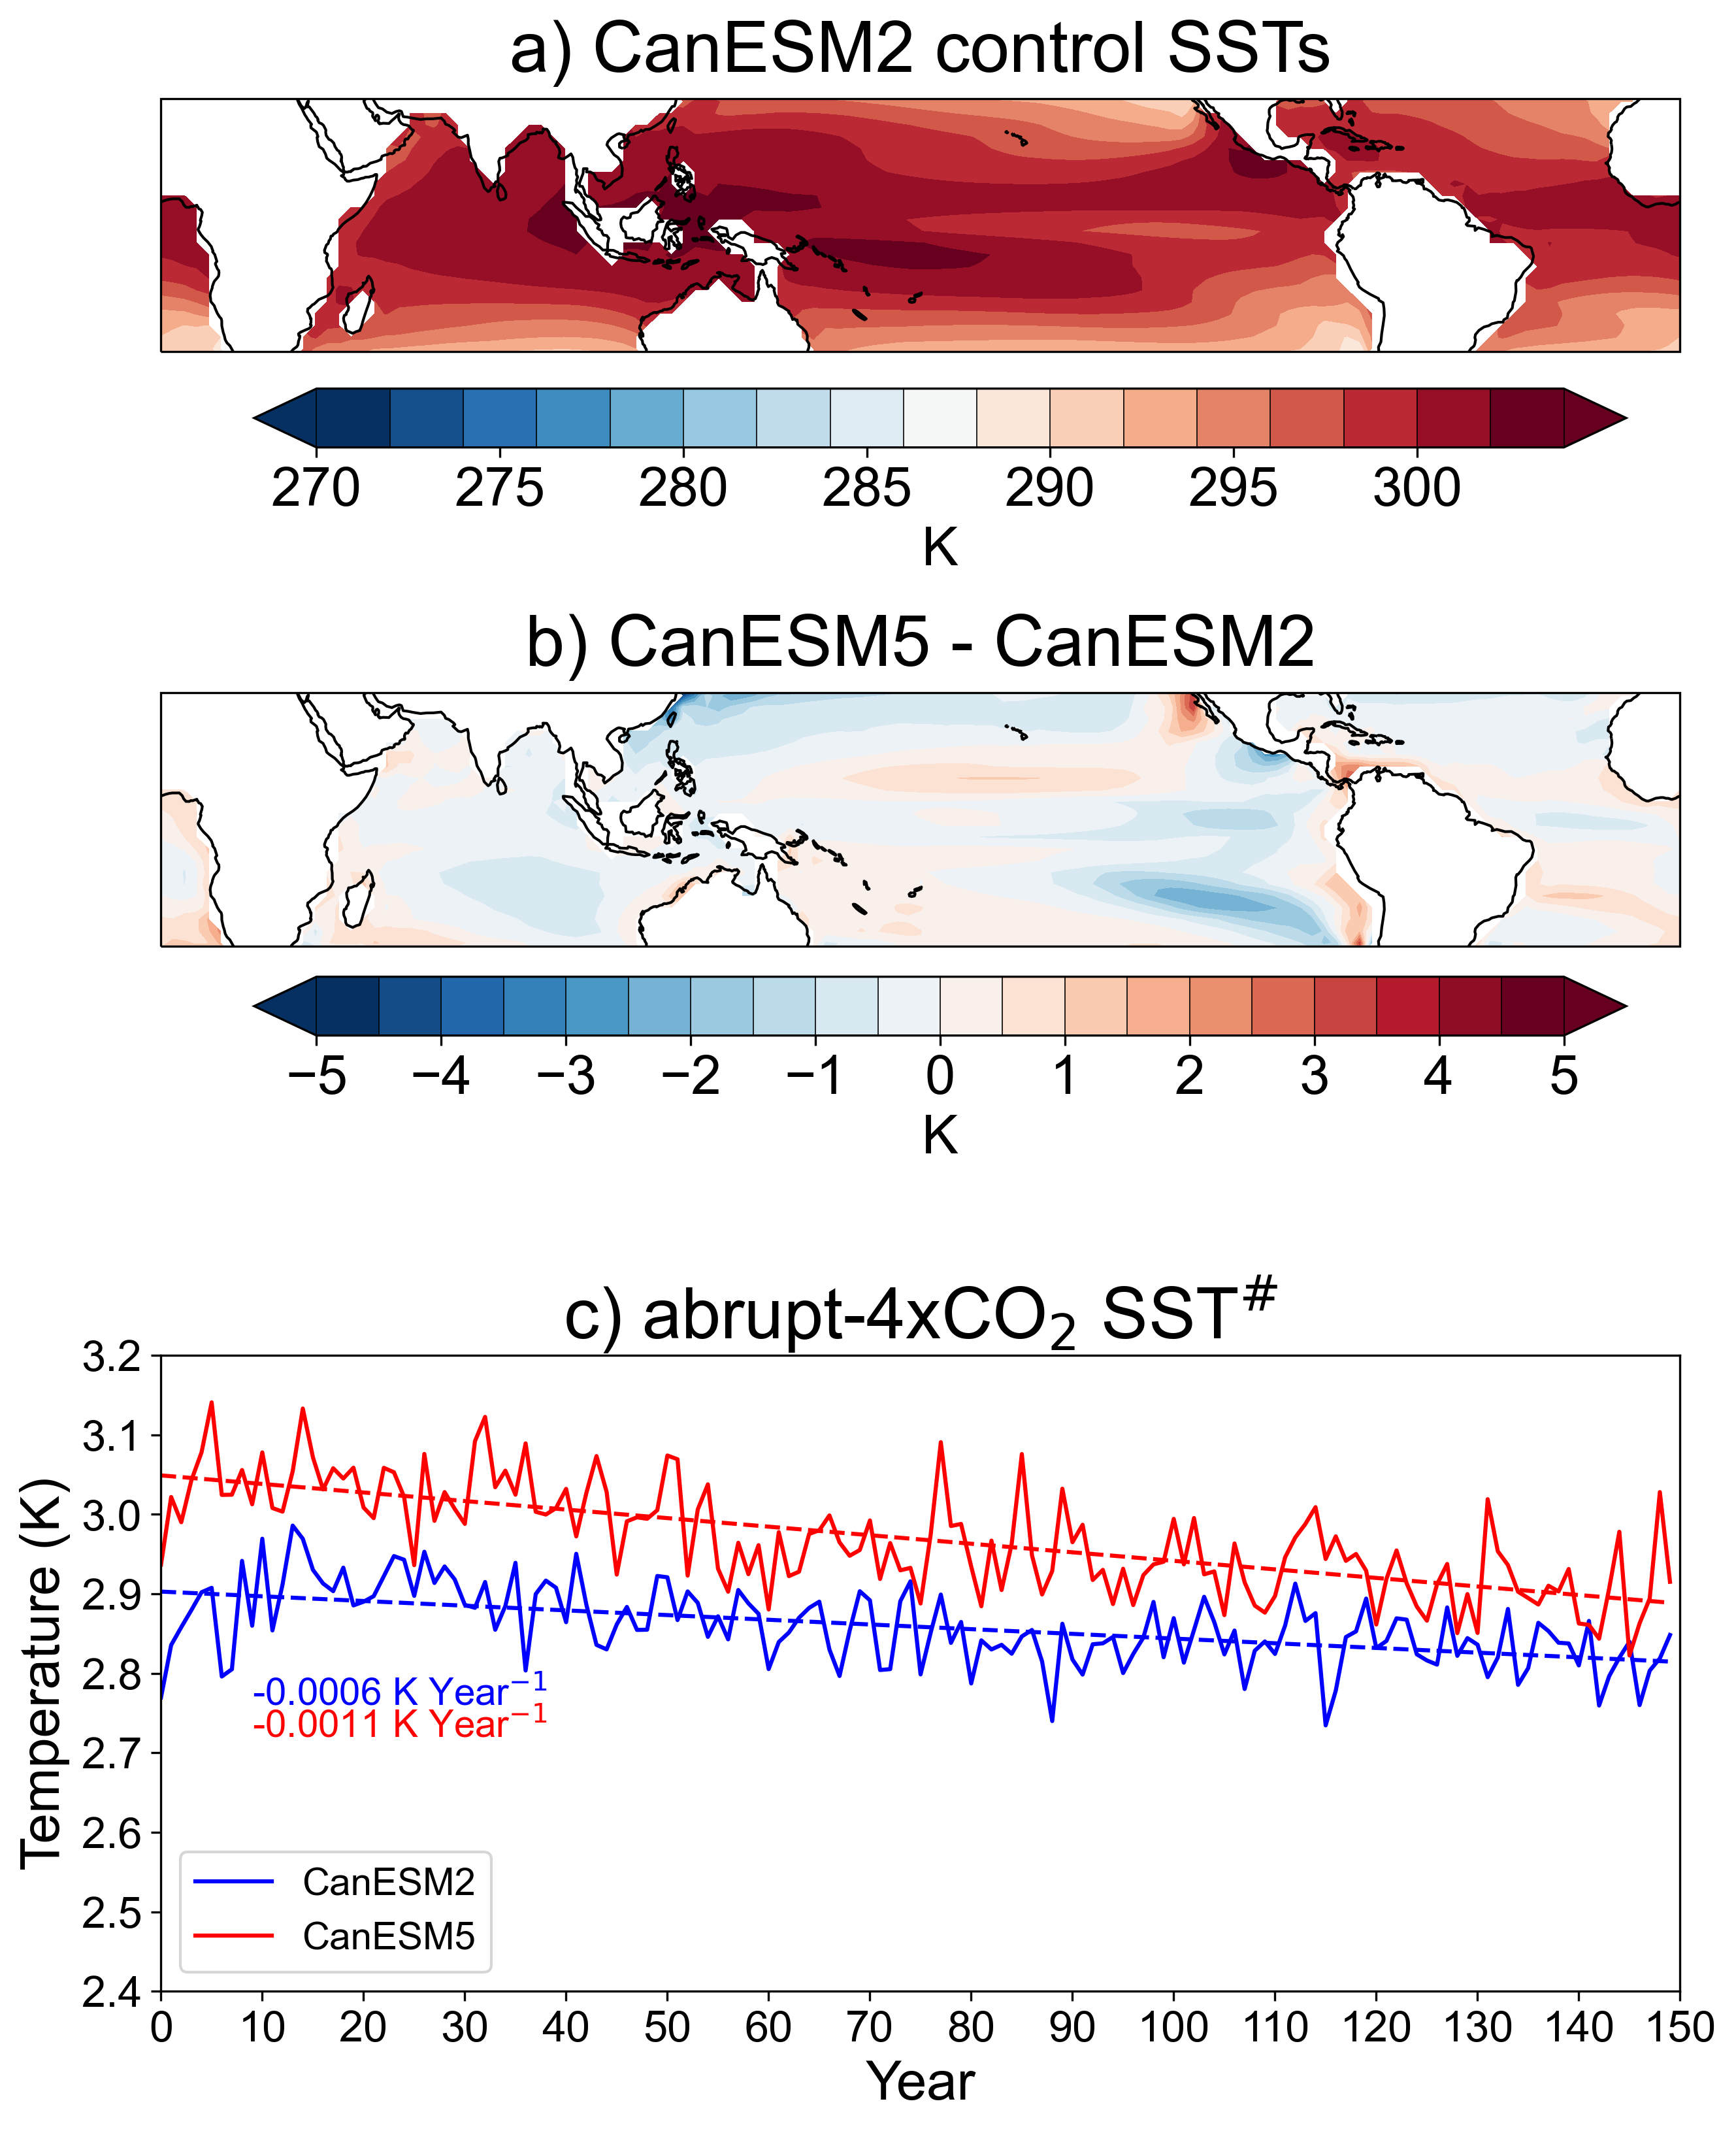

In [8]:

bounds = np.arange(270,305,2)
bounds_ticks = np.arange(270,306,5)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

bounds_diff = np.arange(-5,5.1,0.5)
bounds_ticks_diff = np.arange(-5,5.1,1)
cmap_diff = plt.cm.RdBu_r
norm_diff = mpl.colors.BoundaryNorm(bounds_diff, cmap.N)

fig = plt.figure(figsize=(10,15),dpi=300)
gs = gridspec.GridSpec(5,1, width_ratios=[1],height_ratios=[1,1,1,1,0.7],figure=fig) 
ax = plt.subplot(gs[:1],projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax.set_title('a) CanESM2 control SSTs',fontsize=26,pad=10)
im = ax.contourf(lon_cyc,lat,SST_picon_plot['CanESM2']+273.15,bounds,cmap=cmap,norm=norm,extend='both')
ax.coastlines()

plt.subplot(312)
ax1 = plt.subplot(gs[1:3],projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([-180, 30, -30, 30], crs=ccrs.PlateCarree())
ax1.set_title('b) CanESM5 - CanESM2',fontsize=26,pad=10)
im1 = ax1.contourf(lon_cyc,lat,delta,bounds_diff,cmap=cmap,norm=norm_diff,extend='both')
ax1.coastlines()


plt.subplot(gs[4])
plt.title('c) abrupt-4xCO$_{2}$ SST$^{\#}$',fontsize=26)
plt.plot(SST_sharp['CanESM2'],color='blue',label='CanESM2')
plt.plot(ESM2_pred,color='blue',linestyle='--')
plt.plot(SST_sharp['CanESM5_p2'],color='red',label='CanESM5')
plt.plot(ESM5_pred,color='red',linestyle='--')

plt.text(9,2.76,'-0.0006 K Year$^{-1}$',color='blue',fontsize=14)
plt.text(9,2.72,'-0.0011 K Year$^{-1}$',color='red',fontsize=14)

plt.ylim(2.4,3.2)
plt.yticks(np.arange(2.4,3.21,.1),fontsize=16)
plt.xlabel('Year',fontsize=20)
plt.legend(fontsize=14)
plt.ylabel('Temperature (K)',fontsize=20)
plt.xticks(range(0,151,10),fontsize=16);

plt.subplots_adjust(hspace=-0.6)


cax = fig.add_axes([0.1725, 0.65, 0.7, 0.02])
cbar = plt.colorbar(im,cax=cax,ticks=bounds_ticks,drawedges=True,orientation='horizontal')
cbar.set_label('K',fontsize=20)
cbar.ax.tick_params(labelsize=20)

cax1 = fig.add_axes([0.1725, 0.45, 0.7, 0.02])
cbar1 = plt.colorbar(im1,cax=cax1,ticks=bounds_ticks_diff,drawedges=True,orientation='horizontal')
cbar1.set_label('K',fontsize=20)
cbar1.ax.tick_params(labelsize=20)

plt.savefig('SST_Time.png',bbox_inches='tight')

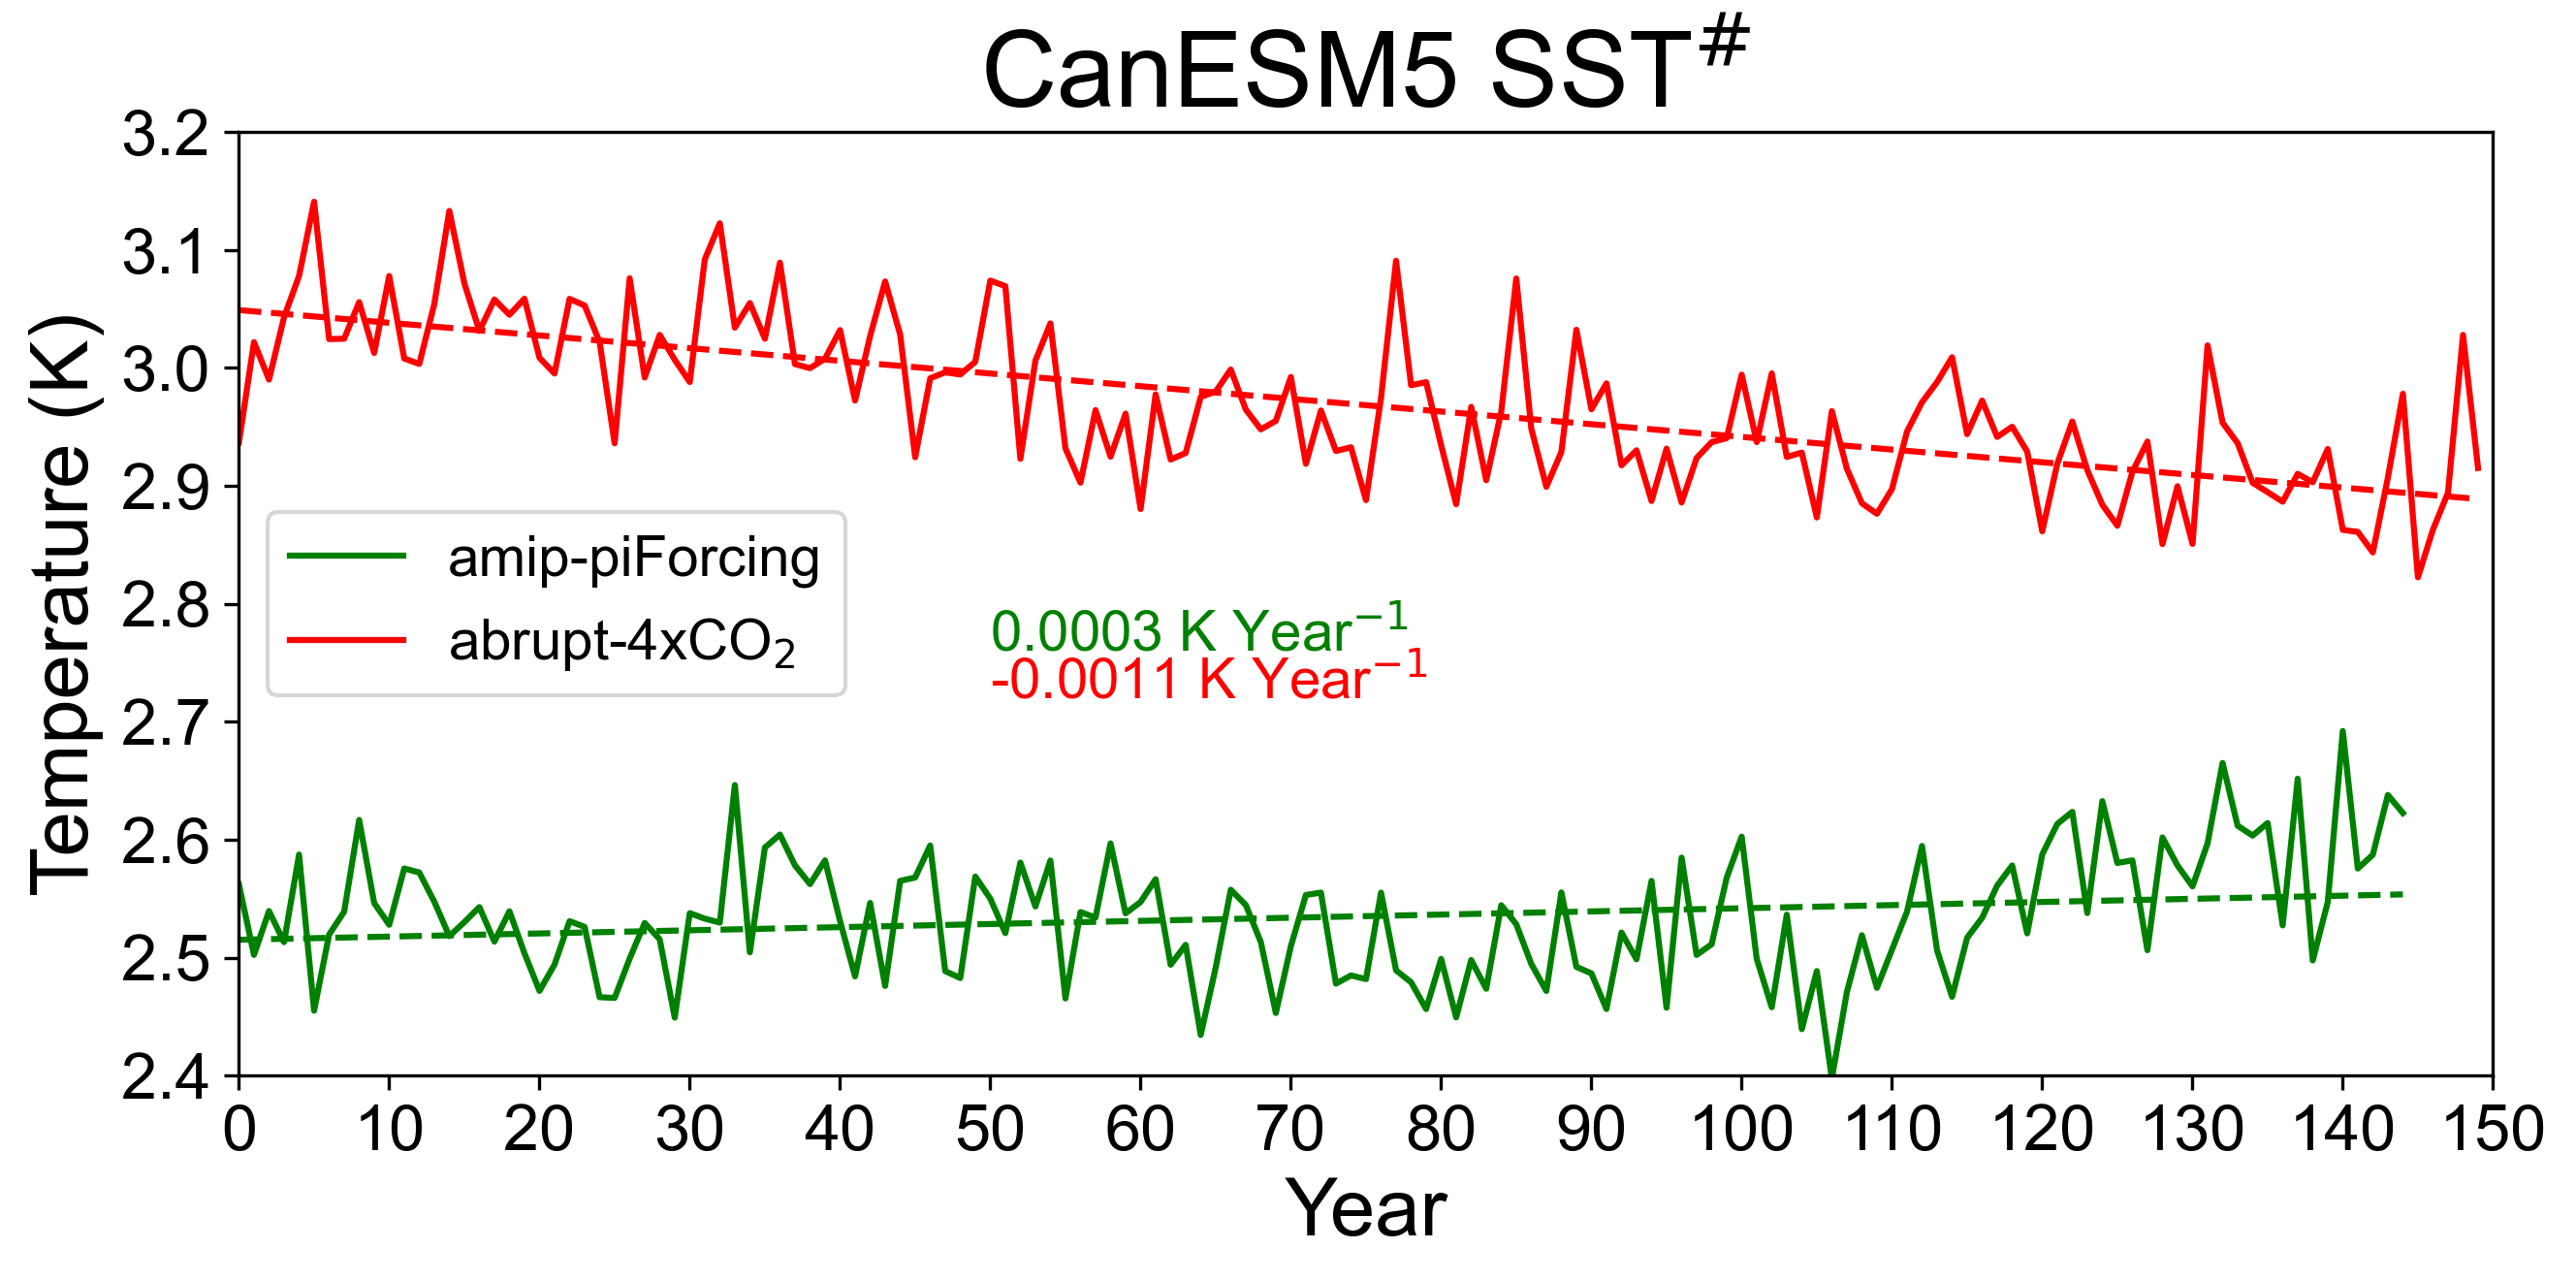

In [16]:

bounds = np.arange(270,305,2)
bounds_ticks = np.arange(270,306,5)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

bounds_diff = np.arange(-5,5.1,0.5)
bounds_ticks_diff = np.arange(-5,5.1,1)
cmap_diff = plt.cm.RdBu_r
norm_diff = mpl.colors.BoundaryNorm(bounds_diff, cmap.N)

fig = plt.figure(figsize=(10,15),dpi=300)
gs = gridspec.GridSpec(5,1, width_ratios=[1],height_ratios=[1,1,1,1,0.7],figure=fig) 

plt.subplot(gs[4])
plt.title('CanESM5 SST$^{\#}$',fontsize=26)
plt.plot(SST_sharp['piForcing'],color='green',label='amip-piForcing')
plt.plot(piForc_pred,color='green',linestyle='--')
#plt.plot(SST_sharp['CanESM2'],color='blue',label='CanESM2')
#plt.plot(ESM2_pred,color='blue',linestyle='--')
plt.plot(SST_sharp['CanESM5_p2'],color='red',label='abrupt-4xCO$_{2}$')
plt.plot(ESM5_pred,color='red',linestyle='--')

plt.text(50,2.76,'0.0003 K Year$^{-1}$',color='green',fontsize=14)
plt.text(50,2.72,'-0.0011 K Year$^{-1}$',color='red',fontsize=14)

plt.ylim(2.4,3.2)
plt.yticks(np.arange(2.4,3.21,.1),fontsize=16)
plt.xlabel('Year',fontsize=20)
plt.legend(fontsize=14)
plt.ylabel('Temperature (K)',fontsize=20)
plt.xticks(range(0,151,10),fontsize=16);

plt.subplots_adjust(hspace=-0.6)

plt.savefig('SST_Time_piforc.png',bbox_inches='tight')